In [2662]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

plt.rcParams["figure.figsize"] = (20, 10)

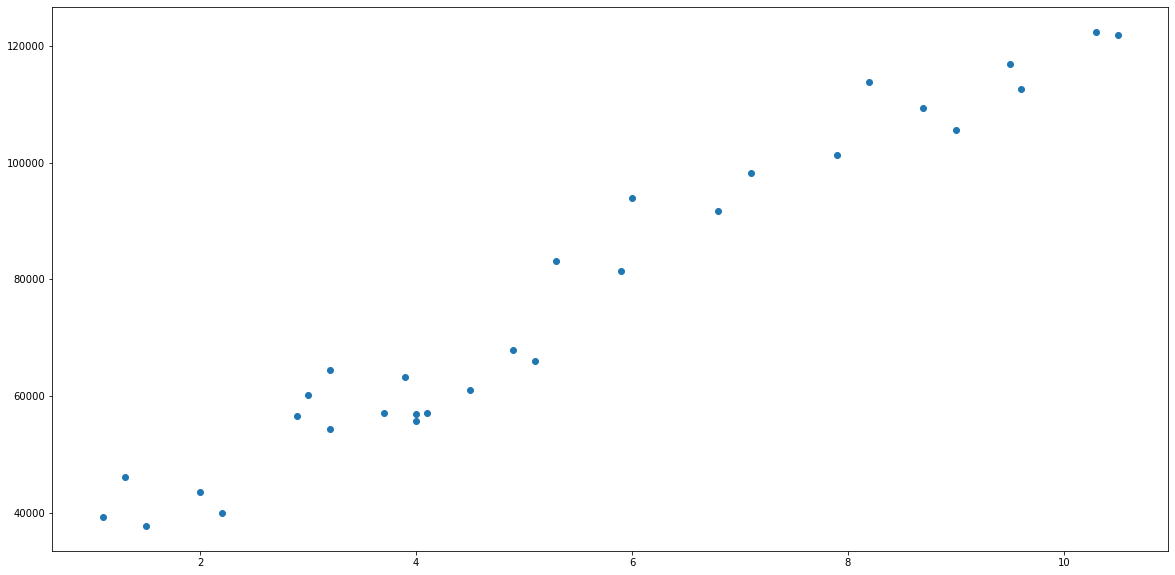

In [2663]:
data = pd.read_csv('Salary_Data.csv')
years = data['YearsExperience']
salary = data['Salary']
plt.plot(years, salary, 'o')

In [2664]:
def draw_row(points):
    res = points[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    x = np.linspace(0, 10, 100)
    ax1.plot(years, salary, 'o')
    ax1.plot(x, res[0] * x + res[1])

    t = np.linspace(-5000, 30000, 100)
    X = np.meshgrid(t, t)
    ax2.contour(X[0], X[1], f_unnormalized(X, range(0, 30)), levels=sorted([f_unnormalized(p, range(0, 30)) for p in points] + list(np.linspace(-1, 1, 100))))
    ax2.plot(points[:, 0], points[:, 1], 'o-', color='red')


def draw_normalized(points):
    res = points[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    x = np.linspace(-2, 2, 100)
    ax1.plot(normalized_exp, normalized_salary, 'o')
    ax1.plot(x, res[0] * x + res[1])

    t = np.linspace(-1, 2.5, 100)
    X = np.meshgrid(t, t)
    ax2.contour(X[0], X[1], f_normalized(X, range(0, 30)), levels=sorted([f_normalized(p, range(0, 30)) for p in points] + list(np.linspace(-1, 1, 100))))
    ax2.plot(points[:, 0], points[:, 1], 'o-', color='red')

Минимизируемая функция: $\sum_{i=0}^{29} (x_0 \times years_i + x_1 - salary_i)^2$

In [2665]:
def f_unnormalized(x, idxs):
    res = 0
    for i in idxs:
        res += (x[0] * years[i] + x[1] - salary[i]) ** 2
    return res

In [2666]:
def const_lr(n, start):
    return start


def exp_lr(n, start):
    k = 0.01
    return start * np.exp(-k * n)


In [2667]:
def partial(f, i, x, idxs):
    h = 1e-3
    x[i] = x[i] + h
    right = f(x, idxs)
    x[i] = x[i] - 2 * h
    left = f(x, idxs)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def grad(f, x, idxs):
    return [partial(f, i, x, idxs) for i in range(len(x))]


def minibatch_grad(func, x, batch):
    idxs = random.sample(range(0, 30), batch)
    return grad(func, x, idxs)

In [2668]:
def minibatch_sgd(f, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start
    points = np.zeros((epoch, 2))
    points[0] = x
    for i in range(1, epoch):
        x = x - lr_strategy(i, lr) * np.array(minibatch_grad(f, x, batch))
        points[i] = x

    return points

In [2669]:
def gd(f, lr, start, lr_strategy=const_lr, epoch=20):
    return minibatch_sgd(f, lr, start, lr_strategy=lr_strategy, epoch=epoch, batch=30)

In [2670]:
def sgd(f, lr, start, lr_strategy=exp_lr, epoch=20):
    return minibatch_sgd(f, lr, start, lr_strategy=lr_strategy, epoch=epoch, batch=1)

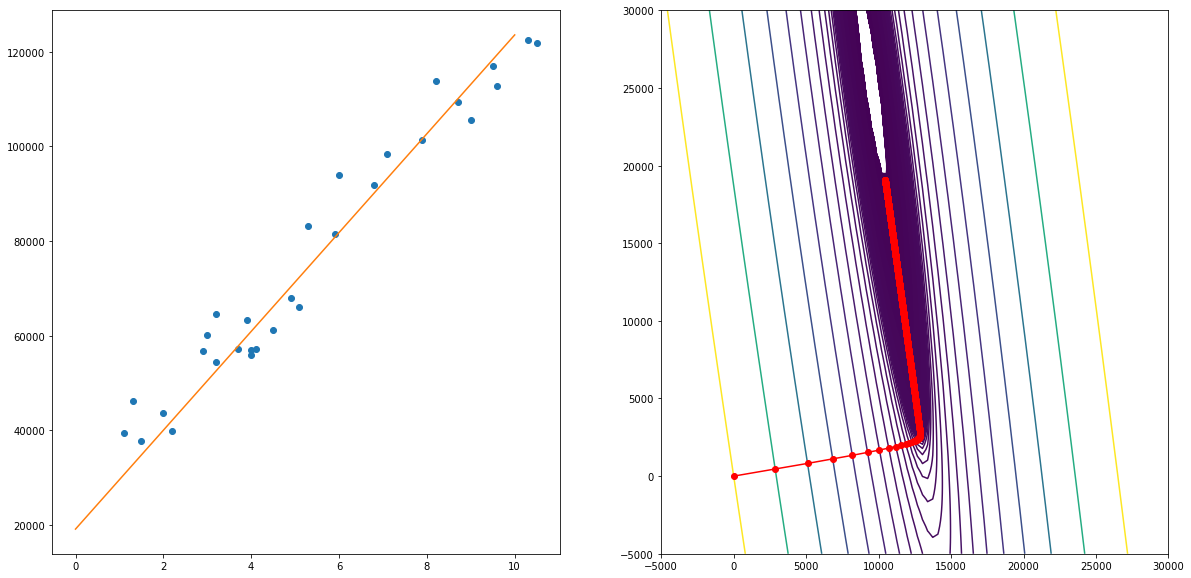

In [2671]:
draw_row(gd(f_unnormalized, 0.0001, start=[1, 1], epoch=1000))

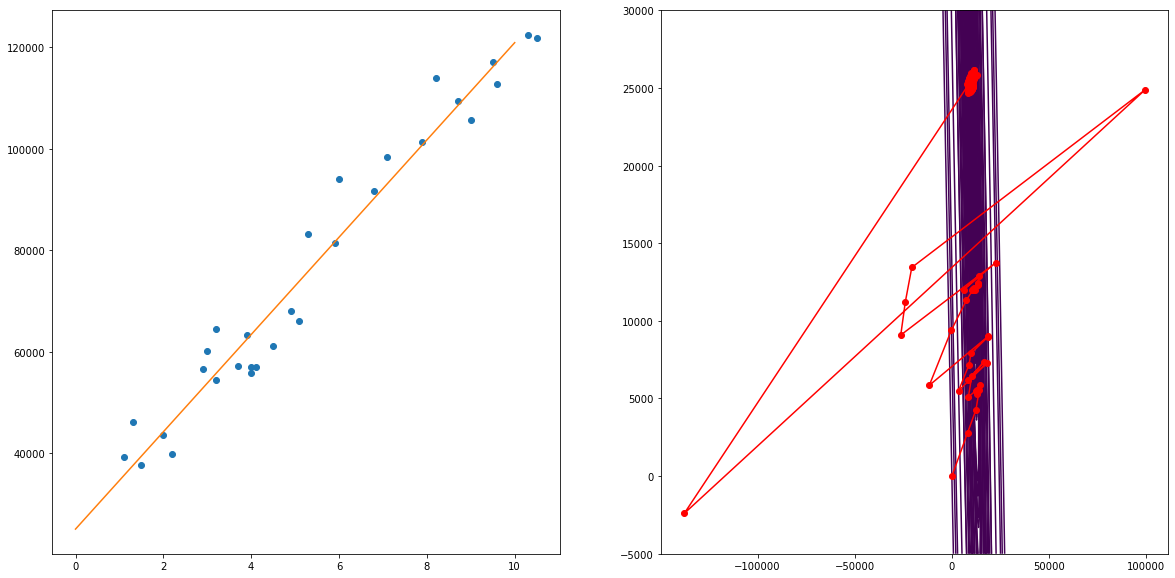

In [2672]:
draw_row(sgd(f_unnormalized, 0.025, start=[1, 1], epoch=1000))

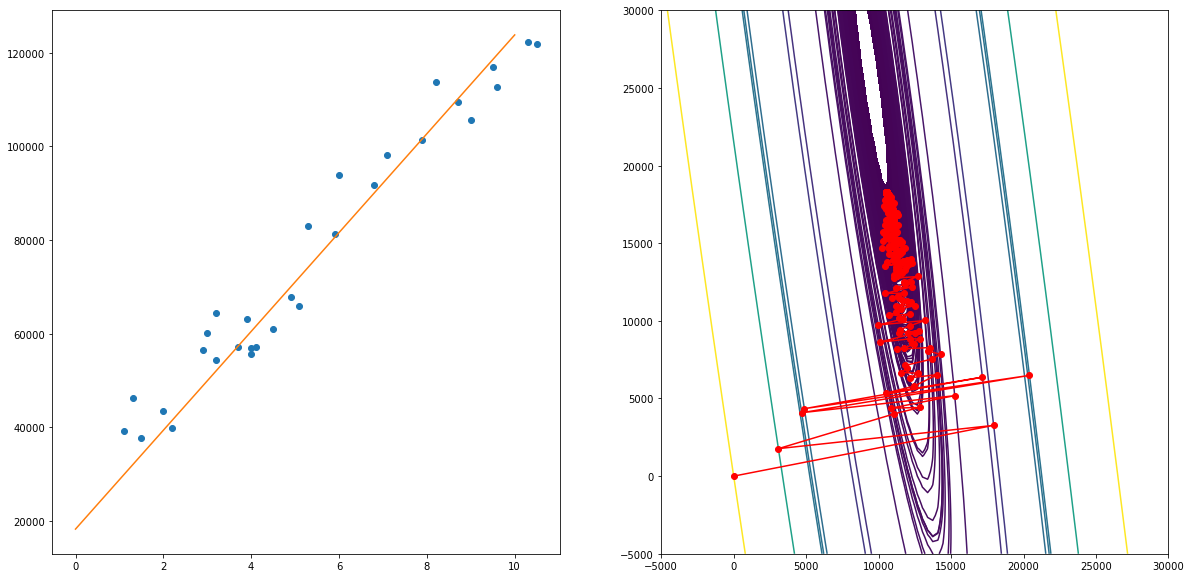

In [2673]:
points = minibatch_sgd(f_unnormalized, 0.005, start=[1, 1], epoch=1000, batch=5)
draw_row(points)

# Задание 2

In [2674]:
avg_exp = years.mean()
dev_exp = years.std()

avg_salary = salary.mean()
dev_salary = salary.std()

In [2675]:
normalized_exp = [(e - avg_exp) / dev_exp for e in years]
normalized_salary = [(e - avg_salary) / dev_salary for e in salary]

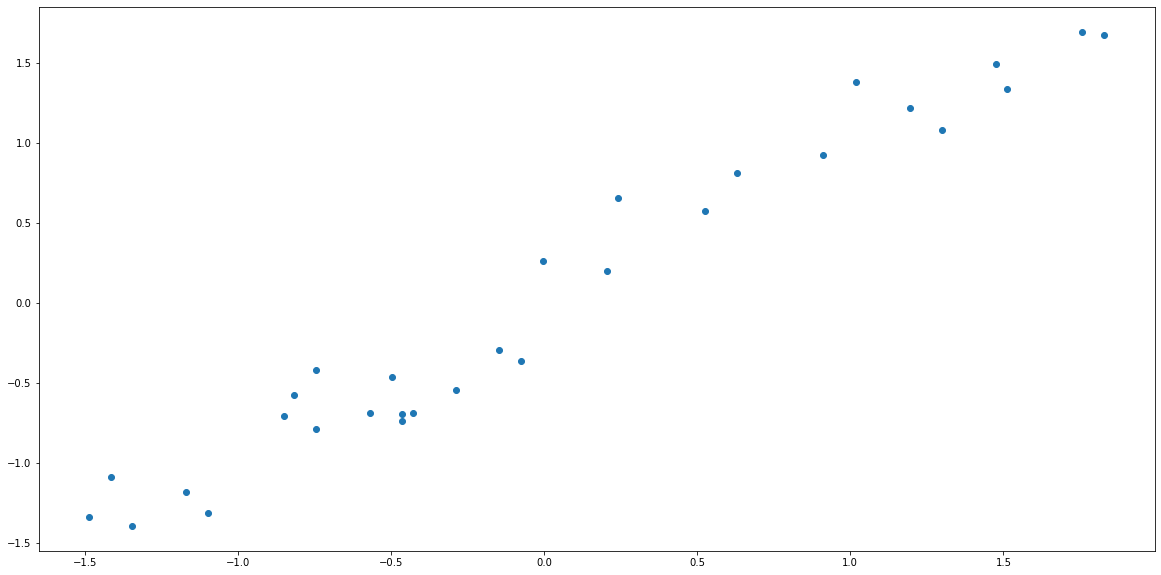

In [2676]:
plt.plot(normalized_exp, normalized_salary, 'o')

In [2677]:
def f_normalized(x, idxs):
    res = 0
    for i in idxs:
        res += (x[0] * normalized_exp[i] + x[1] - normalized_salary[i]) ** 2
    return res

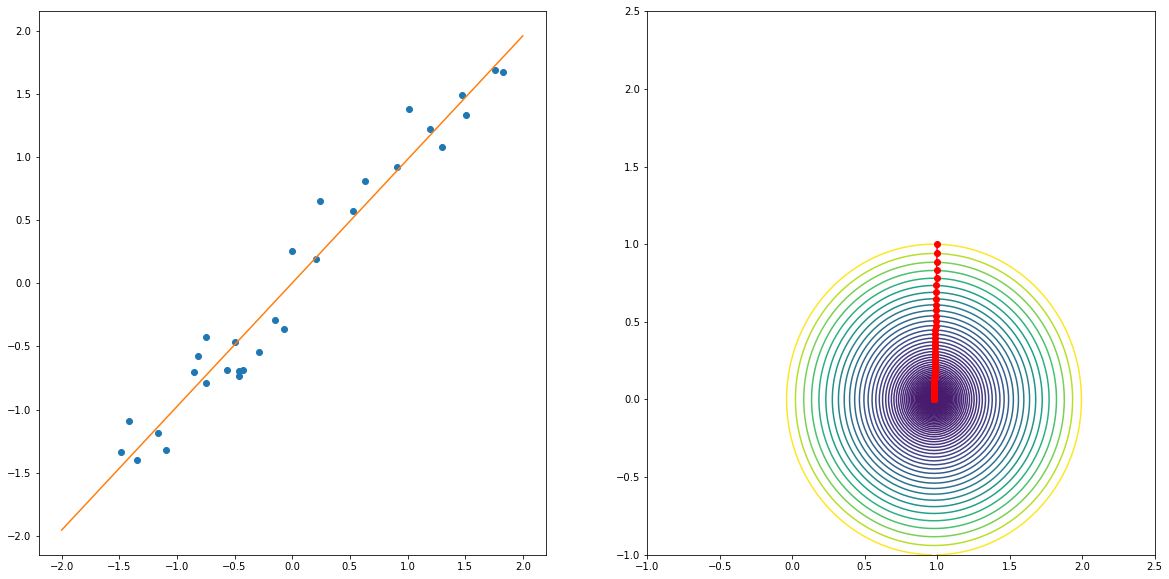

In [2678]:
draw_normalized(gd(f_normalized, 0.001, start=[1, 1], epoch=100))

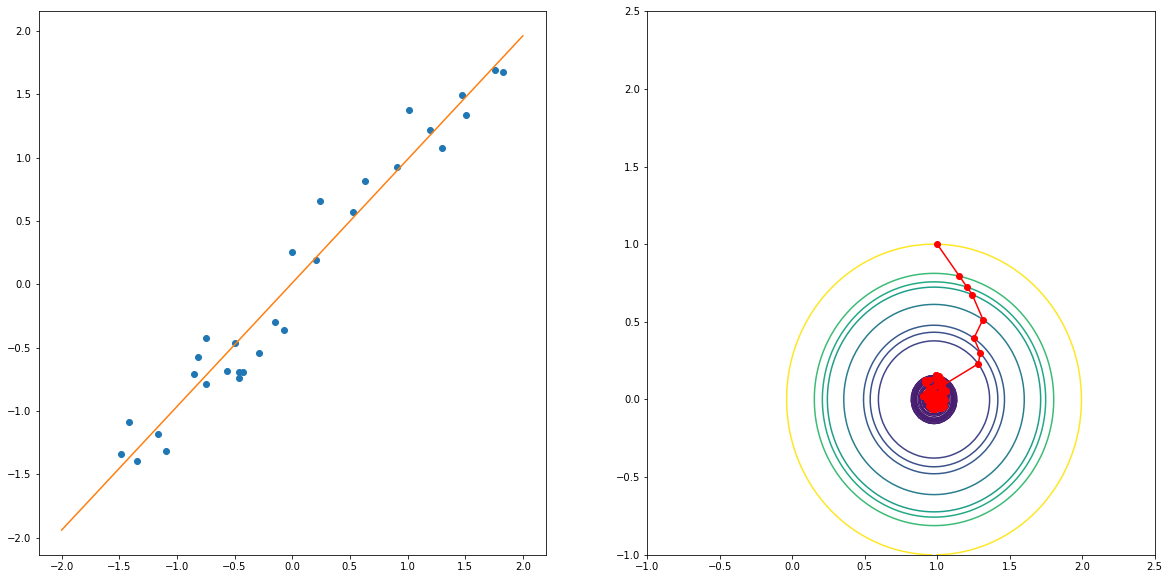

In [2679]:
draw_normalized(sgd(f_normalized, 0.1, start=[1, 1], epoch=1000))

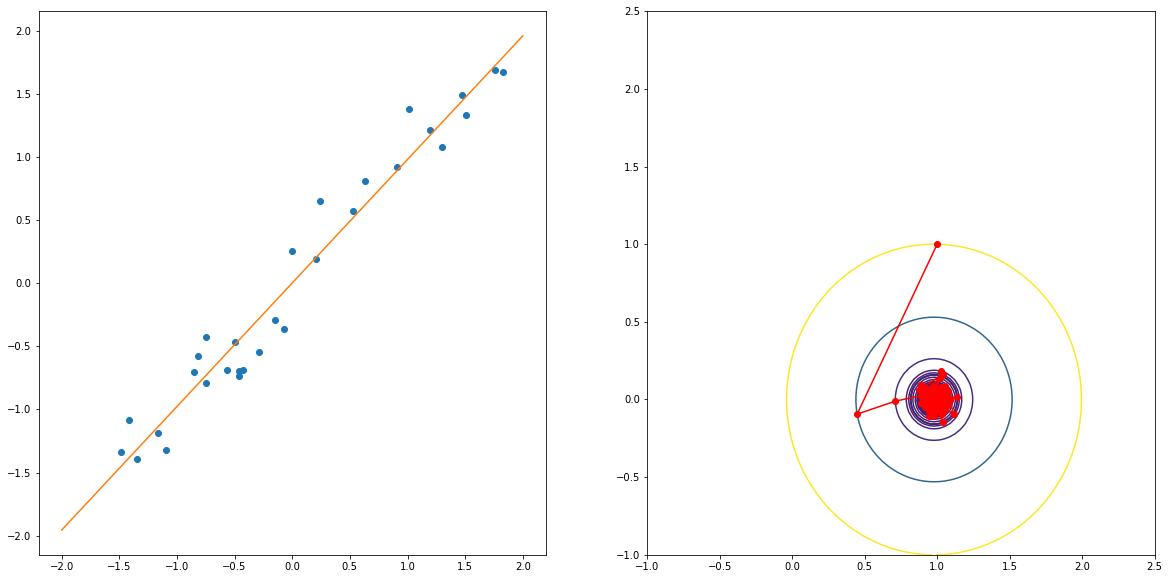

In [2680]:
draw_normalized(minibatch_sgd(f_normalized, 0.1, start=[1, 1], epoch=1000, batch=5))

## Задание 3

### Momentum

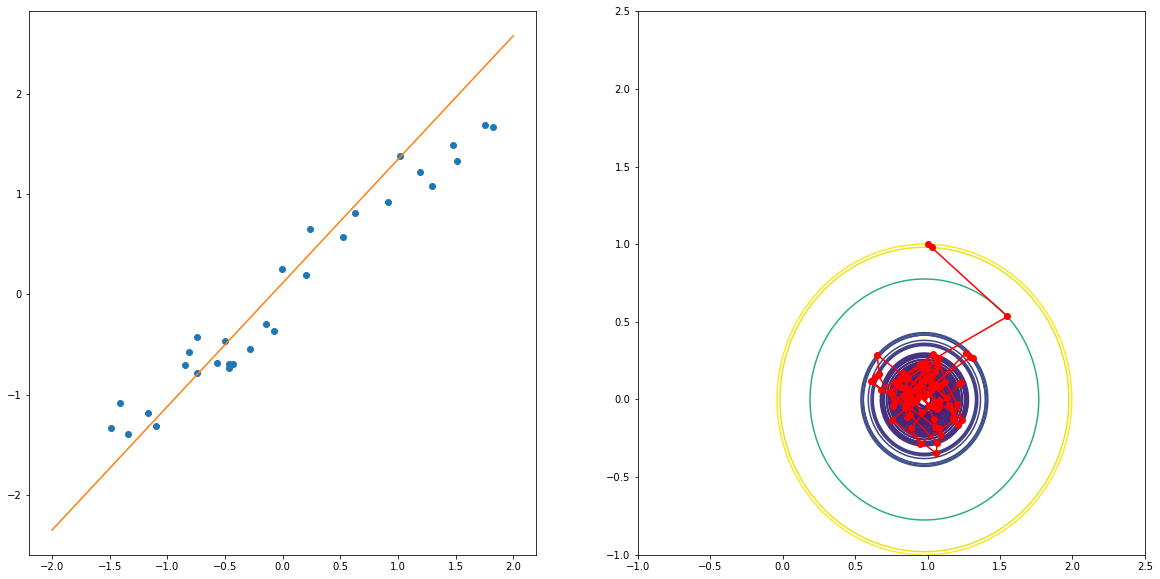

In [2681]:
def sgd_with_momentum(f, b, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start
    points = np.zeros((epoch, 2))
    prev_gr = np.array([0, 0])
    points[0] = x
    for i in range(1, epoch):
        new_grad = np.array(minibatch_grad(f, x, batch))
        new_step = b * prev_gr + lr_strategy(i, lr) * new_grad
        x = x - new_step
        prev_gr = new_grad
        points[i] = x

    return points


points = sgd_with_momentum(f_normalized, b=0.2, lr=0.01, lr_strategy=const_lr, start=[1, 1], epoch=100)
draw_normalized(points)

## Nesterov momentum

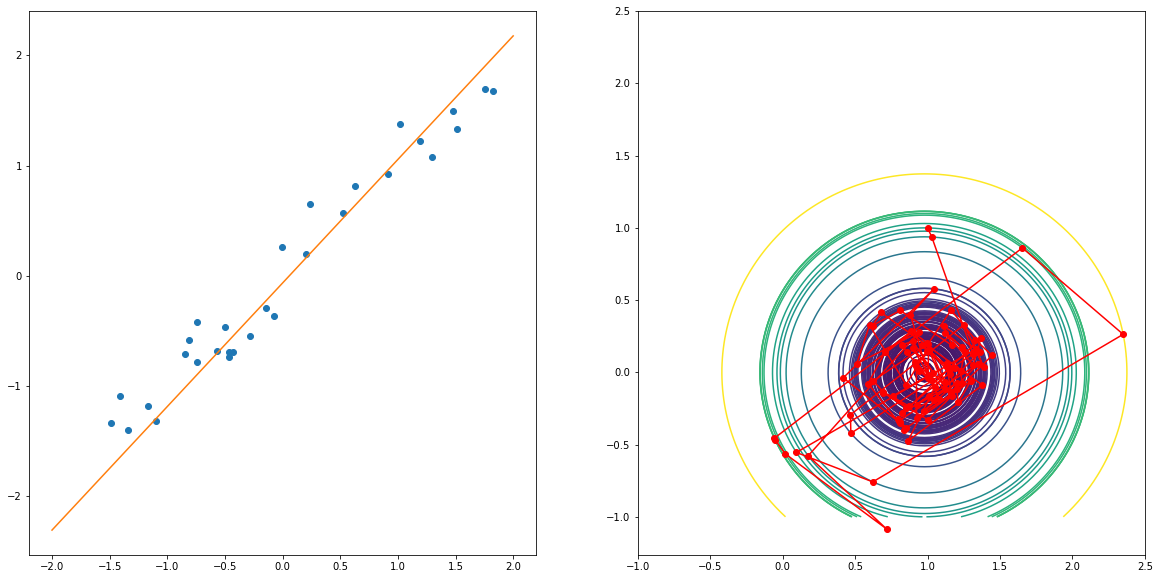

In [2682]:
def sgd_with_nesterov_momentum(f, b, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start
    points = np.zeros((epoch, 2))
    prev_gr = np.array([0, 0])
    points[0] = x
    for i in range(1, epoch):
        new_grad = np.array(minibatch_grad(f, x - b * prev_gr, batch))
        new_step = b * prev_gr + lr_strategy(i, lr) * new_grad

        x = x - new_step
        prev_gr = new_grad
        points[i] = x

    return points


points = sgd_with_nesterov_momentum(f_normalized, b=0.3, lr=0.025, start=[1, 1], epoch=100)
draw_normalized(points)

## AdaGrad

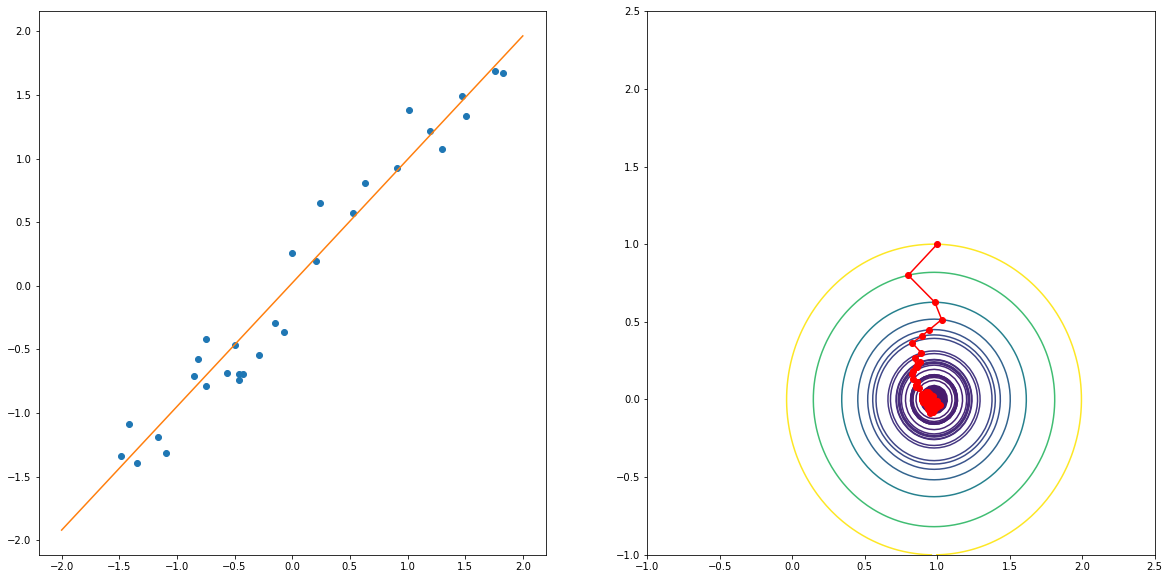

In [2683]:
def adagrad(f, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start
    s = np.array([0, 0])
    points = np.zeros((epoch, 2))
    points[0] = x
    for i in range(1, epoch):
        gr = np.array(minibatch_grad(f, x, batch))
        s = s + np.power(gr, 2)
        x = x - lr_strategy(i, lr) / np.sqrt(s) * gr
        points[i] = x

    return points


points = adagrad(f_normalized, lr=0.2, lr_strategy=const_lr, start=[1, 1], epoch=100)
draw_normalized(points)

## RMSProp

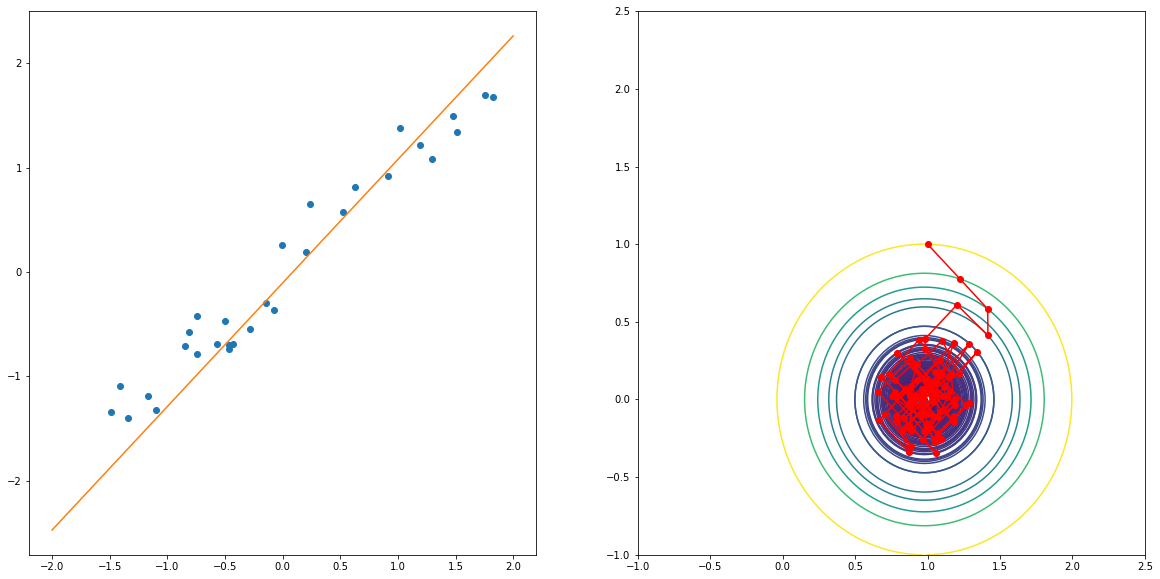

In [2684]:
def rmsprop(f, b, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start
    s = np.array([0, 0])
    points = np.zeros((epoch, 2))
    points[0] = x
    for i in range(1, epoch):
        gr = np.array(minibatch_grad(f, x, batch))
        s = b * s + (1 - b) * np.power(gr, 2)
        x = x - lr_strategy(i, lr) / np.sqrt(s) * gr
        points[i] = x

    return points


points = rmsprop(f_normalized, lr=0.2, b=0.2, lr_strategy=const_lr, start=[1, 1], epoch=100)
draw_normalized(points)

## Adam

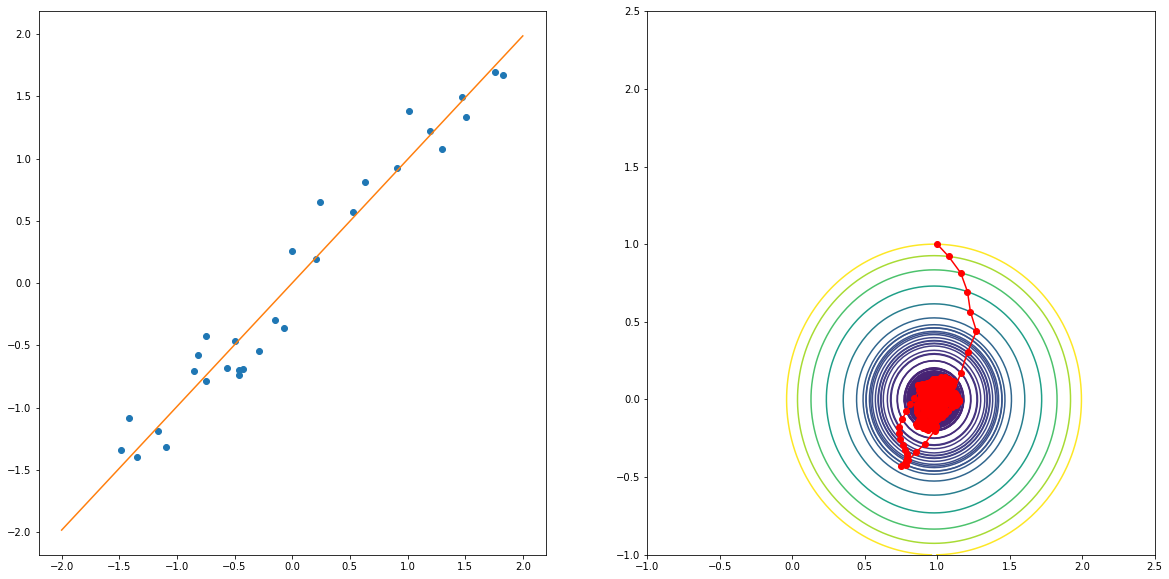

In [2685]:
def adam(f, b1, b2, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start
    s = np.array([0, 0])
    points = np.zeros((epoch, 2))

    prev_grad = np.array([0, 0])
    prev_v = np.array([0, 0])

    points[0] = x
    for i in range(1, epoch):
        gr = np.array(minibatch_grad(f, x, batch))
        g = b1 * prev_grad + (1 - b1) * gr
        v = b2 * prev_v + (1 - b2) * np.power(gr, 2)

        # g_norm = g / (1 - b1 ** (i - 1) + 10**(-8))
        # v_norm = v / (1 - b2 ** (i - 1) + 10**(-8))

        x = x - lr_strategy(i, lr) * g / np.sqrt(v)
        prev_v = v
        prev_grad = g

        points[i] = x

    return points


points = adam(f_normalized, lr=0.025, b1=0.9, b2=0.999, lr_strategy=const_lr, start=[1, 1], epoch=1000)
draw_normalized(points)

# ----------------------------------------------------------------------хуета-------------

In [2686]:
def cancel_condition(i, points):
    if i < 10:
        return False
    if np.std(points[i - 30:i]) < 0.45:
        return True

27
ssssssssssssss


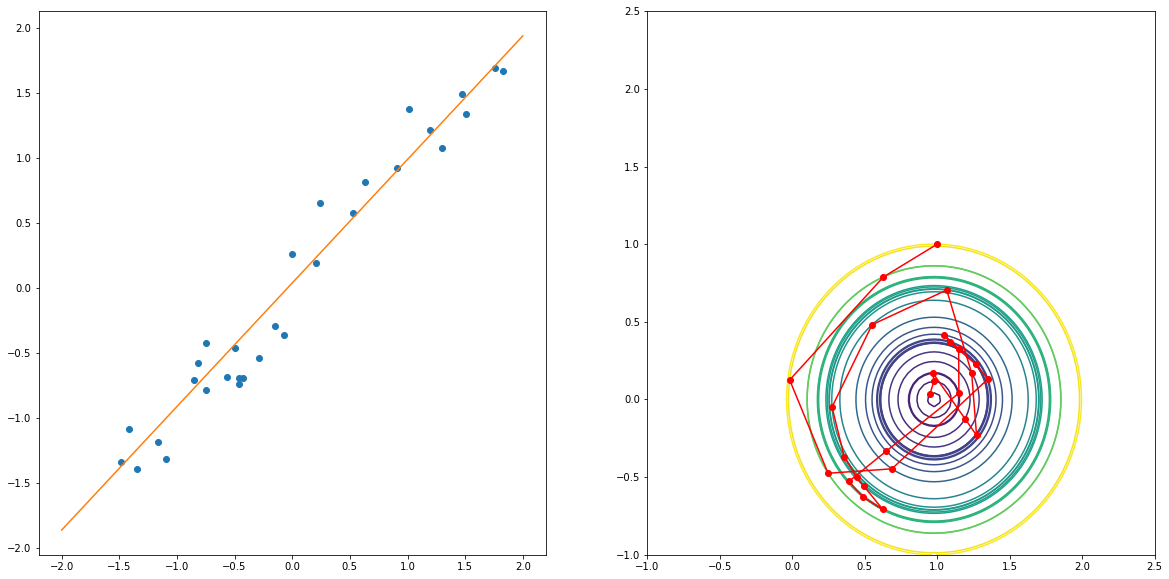

In [2687]:
def sgd_with_momentum(f, b, lr, start, lr_strategy=exp_lr, epoch=20):
    x = start
    points = list()

    points.append(start)

    prev_gr = np.array([0, 0])
    points[0] = x
    for i in range(1, epoch):
        new_grad = np.array(stoch_grad(x))
        new_step = b * prev_gr + lr_strategy(i, lr) * new_grad
        x = x - new_step

        if cancel_condition(i, points):
            print(i)
            print("ssssssssssssss")
            break

        prev_gr = new_grad
        points.append(x)

    return points


points = sgd_with_momentum(f, b=0.2, lr=0.10, start=[1, 1], epoch=10000)
draw_normalized(np.array(points))

27
ssssssssssssss


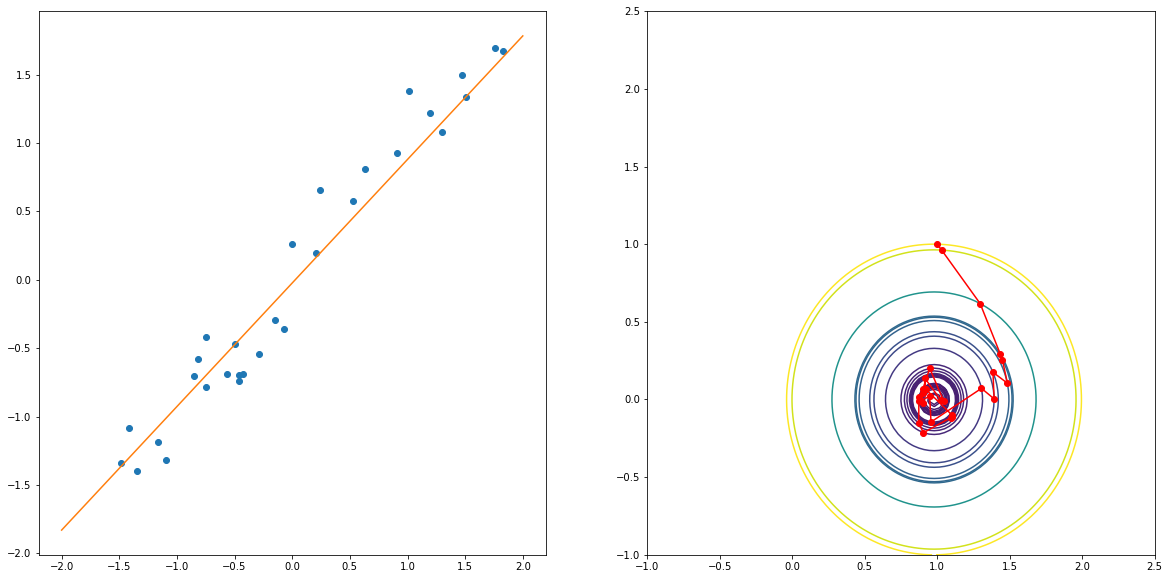

In [2688]:
def sgd_with_nesterov_momentum(f, b, lr, start, lr_strategy=exp_lr, epoch=20):
    x = start

    points = list()
    points.append(start)

    prev_gr = np.array([0, 0])

    for i in range(1, epoch):
        new_grad = np.array(stoch_grad(x - b * prev_gr))
        new_step = b * prev_gr + lr_strategy(i, lr) * new_grad

        if cancel_condition(i, points):
            print(i)
            print("ssssssssssssss")
            break

        x = x - new_step
        prev_gr = new_grad
        points.append(x)

    return points


points = sgd_with_nesterov_momentum(f, b=0.2, lr=0.025, start=[1, 1], epoch=1000)
draw_normalized(np.array(points))

1766
ssssssssssssss


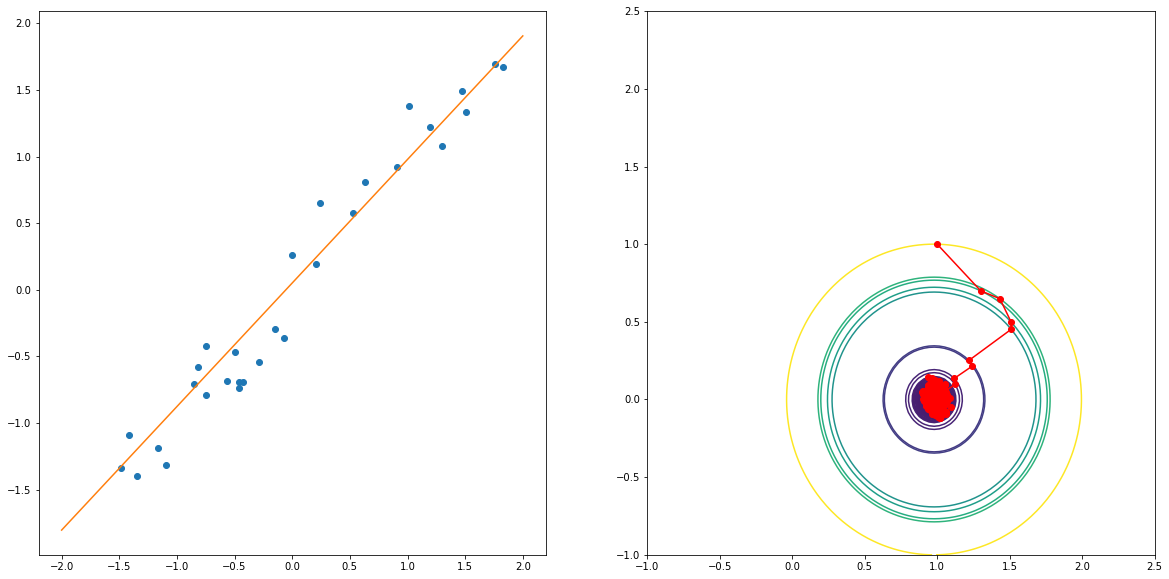

In [2689]:
def adagrad(f, lr, start, lr_strategy=exp_lr, epoch=20):
    x = start
    s = np.array([0, 0])
    points = list()
    points.append(start)
    for i in range(1, epoch):
        gr = np.array(stoch_grad(x))
        s = s + np.power(gr, 2)
        x = x - lr_strategy(i, lr) / np.sqrt(s) * gr
        if cancel_condition(i, points):
            print(i)
            print("ssssssssssssss")
            break

        points.append(x)

    return points


points = adagrad(f, lr=0.3, lr_strategy=const_lr, start=[1, 1], epoch=10000)
draw_normalized(np.array(points))

10
ssssssssssssss


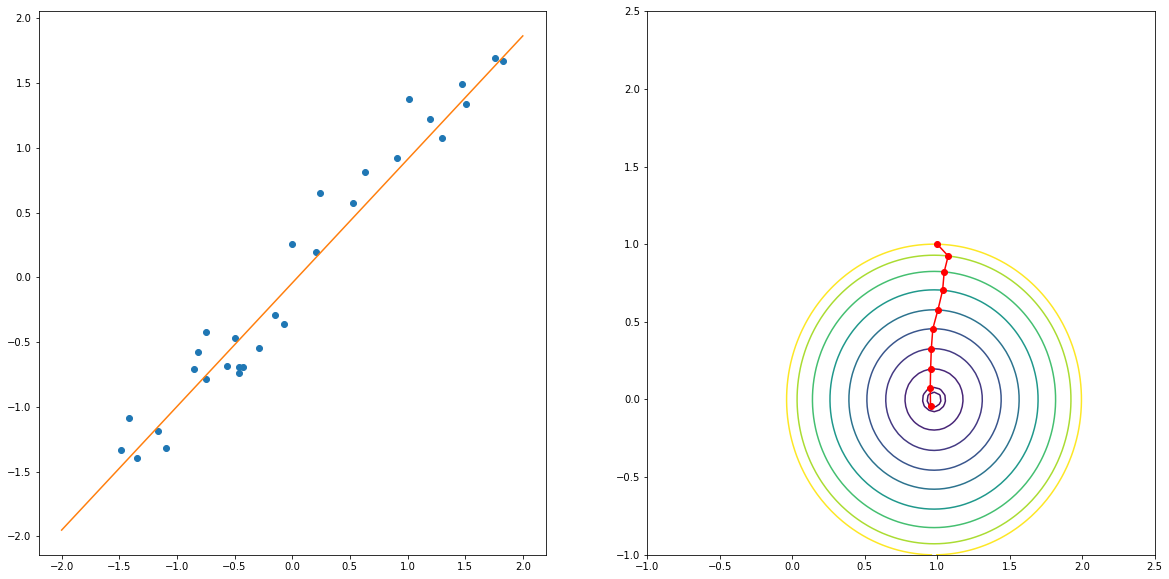

In [2690]:
def adam(f, b1, b2, lr, start, lr_strategy=exp_lr, epoch=20):
    x = start
    s = np.array([0, 0])

    prev_grad = np.array([0, 0])
    prev_v = np.array([0, 0])

    points = list()
    points.append(start)

    for i in range(1, epoch):
        gr = np.array(stoch_grad(x))
        g = b1 * prev_grad + (1 - b1) * gr
        v = b2 * prev_v + (1 - b2) * np.power(gr, 2)

        x = x - lr_strategy(i, lr) * g / np.sqrt(v)

        if cancel_condition(i, points):
            print(i)
            print("ssssssssssssss")
            break

        prev_v = v
        prev_grad = g

        points.append(x)

    return points


points = adam(f, lr=0.024, b1=0.9, b2=0.999, lr_strategy=const_lr, start=[1, 1], epoch=10000)
draw_normalized(np.array(points))